In [12]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


## Useful functions

In [13]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    
    return ds

In [14]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values[0]/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[0,:]
    hybm = np.squeeze(DS.hybm.values)[0,:]
    hyai = np.squeeze(DS.hyai.values)[0,:]
    hybi = np.squeeze(DS.hybi.values)[0,:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [15]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    DS['TKE'].attrs['units']   = 'm2/s2'
    # DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

    DS['WindMagnitude'].attrs['units']   = 'm/s'
    # DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL','CONCLD',
                           ])

    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [16]:
# def preprocess_h1(ds):
    
#     keepVars = ['PHIS','USTAR','WPRTP2_CLUBB','WPTHLP2_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WPRTPTHLP_CLUBB',
#                 'WP4_CLUBB','WPRTP2_ZM_CLUBB','WPTHLP2_ZM_CLUBB','WP2RTP_ZM_CLUBB','WP2THLP_ZM_CLUBB',
#                 'WPRTPTHLP_ZM_CLUBB','THETAL','WP2THLP_CLUBB','WPTHLP2_CLUBB','CDNUMC','CLDBOT','CLDLOW',
#                 'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
#                 'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
#                 'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB','WPRTP_CLUBB',
#                 'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
#                 # 'PRECZ',
#                 'TGCLDCWP','TGCLDLWP','GCLDLWP',
#                 'LHFLX','SHFLX','TREFHT','RHREFHT']
    
#     ds         = cesm_correct_time(ds)
#     ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
#     ## Select the second simulated day for analysis 
#     iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
#                                  (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
#     dsSel            = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]
    
#     # Compute local time 
#     localTimes = dsSel['time'].values - np.timedelta64(5,'h')
#     dsSel      = dsSel.assign_coords({"time": localTimes})
    
#     ## Set some limits for hours? 
#     hrStart = 7
#     hrEnd   = 21

#     iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
#     dsSel      = dsSel.isel(time=iHoursSCAM)
    
#     ## Resample to 30m means? 
#     # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    
            
#     return dsSel

In [17]:
## Pre-processing to get CLM data

def preprocessCLM_h0(ds):
    
    # keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA','USTAR','WSTAR','ZETA',
    #                 'QVEGT','QVEGE','QSOIL']

    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 7
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
    dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    
    return dsSel



In [18]:
## Pre-processing to get CLM data

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 7
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
    dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean()
    
    return dsSel


In [19]:
def preprocess_h0(ds):
    
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT','PBLH'
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','WPRTP2_CLUBB','WPTHLP2_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WPRTPTHLP_CLUBB',
                'WP4_CLUBB','WPRTP2_ZM_CLUBB','WPTHLP2_ZM_CLUBB','WP2RTP_ZM_CLUBB','WP2THLP_ZM_CLUBB',
                'WPRTPTHLP_ZM_CLUBB','THETAL','WP2THLP_CLUBB','WPTHLP2_CLUBB','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB','WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT',
                ## Add budget terms 
                # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
                # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
                # 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
                # 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                # 'wpthlp','wprtp',
                # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
                # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
                # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
                # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
                # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
                # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
                # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                ]
    
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    # dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 7
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
    dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    
        
    return dsSel

In [20]:
def preprocess_LES(ds):
    keepVars = ['XTIME','AVS_SH','AVS_LH','AVS_LWP','AVS_RAIN','AVP_QC','AVP_QV',
                'AVP_Z','AVP_P','AVP_THL','AVP_TH','AVP_LWC','AVP_IWC']
    
    dsTimes = ds.Times.load()
    
    times = []
    for iT in range(len(dsTimes.values)):
        timeNow = datetime.datetime.strptime(dsTimes.astype(str).values[iT], '%Y-%m-%d_%H:%M:%S')
        times   = np.append(times, timeNow)

    ds = ds.assign_coords({"Time": times, 
                           "west_east": (ds.west_east.load().values)*0.250,
                           "south_north": (ds.south_north.load().values)*0.250})
    
    ## Convert to local time and drop first time 
    ds['Time'] = ds['Time'].values - np.timedelta64(5, 'h') # And convert to local time by -5hrs 

#     iTimes = np.where(testDS['Time'].values >= (testDS['Time'].values[0] + np.timedelta64(1, 'h')) )[0]
#     testDS = testDS.isel(Time=iTimes)
    
    return ds[keepVars].load()


In [21]:
def getStatSigCI(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0            
            
            
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [22]:
def getMaxValHeightTime(DS,varName, maxLev,levName,timeName):
    iMax = np.where(DS[levName].values>=maxLev)[0]
    DS   = DS.isel(levInterp=iMax.astype(int))
    
    maxValTemp = np.nanmax(np.squeeze(DS[varName].values))
    minValTemp = np.nanmin(np.squeeze(DS[varName].values))
    
    if np.abs(maxValTemp)>np.abs(minValTemp):
        maxVal = maxValTemp
    elif np.abs(maxValTemp)<np.abs(minValTemp):
        maxVal = minValTemp
    else: 
        maxVal = maxValTemp
        
    iMax = np.where(DS[varName].values == maxVal)
    hgtMax = DS[levName].values[iMax[1]]
    timeMax = DS[timeName].values[iMax[0]]
    
    return maxVal, hgtMax, timeMax

## Debugging

In [24]:
mainDir = '/glade/u/home/mdfowler/temp/'
HOMcase = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlx_fixEvap.LASSO_20180605'
HETcase = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlx_fixEvap.LASSO_20180605'

HOMlogFile = mainDir+HOMcase+'/run/logs/atm.log.582583.izumi.cgd.ucar.edu.221215-101719'
HETlogFile = mainDir+HETcase+'/run/logs/atm.log.582741.izumi.cgd.ucar.edu.221215-123240'

with open(HOMlogFile) as f:
    HOMlines = f.readlines()

with open(HETlogFile) as f:
    HETlines = f.readlines()
    

In [27]:

matchStart = ' nstep, te       85'
matchEnd   = ' nstep, te       86'

for iLines in range(len(HOMlines)):
    if HOMlines[iLines].startswith(matchStart)==True:
        iStart_HOM = iLines
    if HOMlines[iLines].startswith(matchEnd)==True:
        iEnd_HOM = iLines
        
for iLines in range(len(HETlines)):
    if HETlines[iLines].startswith(matchStart)==True:
        iStart_HET = iLines
    if HETlines[iLines].startswith(matchEnd)==True:
        iEnd_HET = iLines       
        
print(iStart_HOM, iEnd_HOM)
print(iStart_HET, iEnd_HET)



8511 8553
11991 12323


In [31]:
selHOMlines = HOMlines[iStart_HOM:iEnd_HOM]
selHETlines = HETlines[iStart_HET:iEnd_HET] 


In [57]:
## Say I want just the first iteration through everything...
selHETlines = selHETlines[0:101]
selHOMlines = selHOMlines[0:30]

In [58]:
for i in range(len(selHOMlines)):
    print(selHOMlines[i])

 nstep, te       85   0.26312917303576880E+10   0.26312141646342192E+10  -0.13114680018508830E-01   0.96868392585966008E+05   0.20548077300190926E+03

  Parameters in iop_forcing :

  scm_iop_lhflxshflxTg = T

            scm_iop_Tg = F

          scm_crm_mode = F

            have_lhflx = T

            have_shflx = T

               have_Tg = T

               Tground =   292.327148437500     

 MDF (debug): wthv =   1.821091038469464E-002

 MDF (debug): wthl =   1.664963184555937E-002

 MDF (debug): wqt =   8.707780813278878E-006

 MDF (debug): wstar =   0.478061702808614     

 MDF (debug): qstar   =   1.821476341259014E-005

 MDF (debug): thvstar =   3.809322160236951E-002

 MDF (debug): sigmaqt =   5.264066626238550E-005

 MDF (debug): sigmathv =   0.110089410430848     

 MDF (debug): wthv =   1.821091038469464E-002

 MDF (debug): wthl =   1.664963184555937E-002

 MDF (debug): wqt =   8.707780813278878E-006

 MDF (debug): wstar =   0.478014239088488     

 MDF (debug): qstar   =

In [59]:
for i in range(len(selHETlines)):
    print(selHETlines[i])

 nstep, te       85   0.26312917225667682E+10   0.26312141543595090E+10  -0.13115099973546202E-01   0.96868392585966008E+05   0.20548077300190926E+03

  Parameters in iop_forcing :

  scm_iop_lhflxshflxTg = T

            scm_iop_Tg = F

          scm_crm_mode = F

            have_lhflx = T

            have_shflx = T

               have_Tg = T

               Tground =   292.327148437500     

 MDF (debug): patch area   3.237421461195519E-003

 MDF (debug): wthvPatch =   0.114582564826315     

 MDF (debug): patchLH =   9.641189850916117E-006

 MDF (debug): patchSH =   5.545486908809709E-002

 MDF (debug): patchFV =   0.200410314639130     

 MDF (debug): qstar   =   4.810725370236851E-005

 MDF (debug): thvstar =   0.571739857964094     

 MDF (debug): sigmaqt =   1.390299631998450E-004

 MDF (debug): sigmathv =    1.65232818951623     

 MDF: patchPlumesTotal =            0

 MDF (debug): patch area   1.463820825006332E-003

 MDF (debug): wthvPatch =   0.115484262322455     

 MDF

In [72]:
patchArea = []
matchString = ' MDF (debug): patch area'
for iLines in range(len(selHETlines)): 
    if selHETlines[iLines].startswith(matchString)==True:
        patchArea = np.append(patchArea, float(selHETlines[iLines].split('  ')[1].split('\n')[0]))
    

In [73]:
patchLH = [] 
matchString = ' MDF (debug): patchLH'
for iLines in range(len(selHETlines)): 
    if selHETlines[iLines].startswith(matchString)==True:
        patchLH = np.append(patchLH, float(selHETlines[iLines].split('=')[1].split('\n')[0]))
        

In [74]:
patchSH = [] 
matchString = ' MDF (debug): patchSH'
for iLines in range(len(selHETlines)): 
    if selHETlines[iLines].startswith(matchString)==True:
        patchSH = np.append(patchSH, float(selHETlines[iLines].split('=')[1].split('\n')[0]))

In [75]:
patchWTHV = [] 
matchString = ' MDF (debug): wthvPatch'
for iLines in range(len(selHETlines)): 
    if selHETlines[iLines].startswith(matchString)==True:
        patchWTHV = np.append(patchWTHV, float(selHETlines[iLines].split('=')[1].split('\n')[0]))

In [76]:
patchArea

array([3.23742146e-03, 1.46382083e-03, 6.57151220e-03, 2.55558264e-01,
       2.21671438e-01, 4.87410961e-01, 2.25548209e-02, 8.84902129e-06,
       2.94967376e-06, 2.94967376e-06, 2.06477160e-06, 8.84902164e-07,
       7.57031528e-04, 2.52343843e-04, 2.52343843e-04, 1.26171921e-04,
       1.26171921e-04])

In [77]:
patchLH

array([9.64118985e-06, 3.42091123e-06, 3.76591060e-06, 3.62568777e-06,
       3.68711923e-06, 3.37069787e-06])

In [86]:
print('   Area     LH       SH        wthv')
for iPatch in range(len(patchLH)):
    print('  %.3f %9.2e %9.2e %9.2e' % (patchArea[iPatch],
                              patchLH[iPatch],
                              patchSH[iPatch],
                              patchWTHV[iPatch]))

   Area     LH       SH        wthv
  0.003  9.64e-06  5.55e-02  1.15e-01
  0.001  3.42e-06  9.45e-02  1.15e-01
  0.007  3.77e-06  1.07e-01  1.30e-01
  0.256  3.63e-06  6.30e-02  8.53e-02
  0.222  3.69e-06  6.30e-02  8.56e-02
  0.487  3.37e-06  6.43e-02  8.49e-02


In [87]:
0.487+0.222+0.256

0.965

## Read in data

In [12]:
archiveDir    = '/glade/work/mdfowler/CLASP/CLUBB_MF/SCAM_histFiles/LASSO_LESdays/'

case_names = ['HOM_MF',
              'HET_MF',
             ]

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchData'

caseStrings = ['FALSE_setSfcFlx_fixEvap.LASSO_',
               'TRUE_setSfcFlx_fixEvap.LASSO_',
              ]

for iCase in range(len(case_names)):
    print('*** Starting on case %s ***' % (case_names[iCase]))
    
    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(archiveDir+caseStart+caseStrings[iCase]+'*cam.h0*'))
    
    listFilesCLM_h1 = np.sort(glob.glob(archiveDir+caseStart+caseStrings[iCase]+'*clm2.h1*'))
    listFilesCLM_h0 = np.sort(glob.glob(archiveDir+caseStart+caseStrings[iCase]+'*clm2.h0*'))

    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded with mfdataset')
        
    ## Process data 
    procDS = process_camData( case_h0 )
            
    ## Combine all the cases into 
    case_allDays      = procDS.assign_coords({"case":  case_names[iCase]})
    
    if iCase==0:
        scamDS   = case_allDays
    else: 
        scamDS   = xr.concat([scamDS, case_allDays], "case") 
        
        
    # Read in CLM datasets too 
    caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h0 files loaded with mfdataset')

    caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h1 files loaded with mfdataset')

    caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
    caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

    if iCase==0:
        clmDS_h0 = caseCLMh0_allDays
        clmDS_h1 = caseCLMh1_allDays
    else: 
        clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
        clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 

            
    print('Done with case %i of %i ' % (iCase+1, len(case_names)))
    

*** Starting on case HOM_MF ***
h0 files loaded with mfdataset
Beginning interpolation...
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset
Done with case 1 of 2 
*** Starting on case HET_MF ***
h0 files loaded with mfdataset
Beginning interpolation...
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset
Done with case 2 of 2 


**The run start date *is* changing right??**

**Continue on as normal below here**

In [20]:
# ## Assign a more helpful itme coordinate to clm datasets 
# clmDS_h0['time'] = scamDS['time']
# clmDS_h1['time'] = scamDS['time']


ValueError: conflicting sizes for dimension 'time': length 0 on 'mcdate' and length 1011 on 'time'

In [14]:
uniqDays_scamHOM = scamDS.sel(case='HOM_MF').resample(time='1D').mean().dropna(dim='time').time.values

print('SCAM days:    ',    len(uniqDays_scamHOM))

SCAM days:     74


#### Read in WRF-LES data

In [15]:
datesTXT = '/glade/scratch/mdfowler/CLASP_ensOutput/LESdays/makeConcatOutput/WRFLESdateStrings.txt'

LESdates = pd.read_csv(datesTXT, sep=" ", header=None)
LESdates.columns = ['dateVal']

allYears   = [] 
allMonths  = []
allDays    = []

for iDate in range(len(LESdates.dateVal)):
    allYears   = np.append(allYears,   LESdates.dateVal.values.astype(str)[iDate][0:4]) 
    allMonths  = np.append(allMonths,  LESdates.dateVal.values.astype(str)[iDate][4:6])
    allDays    = np.append(allDays,    LESdates.dateVal.values.astype(str)[iDate][6::])


In [19]:
lesDir        = '/glade/work/mdfowler/CLASP/LESdata_fromJason/allDays_250mRes/'

## Fix time arrays to be useful in the LES cases
startTime = datetime.datetime(2016,1,1, 0,0,0)

# Empty arrays: 
dateStringsUsed   = []
circMetric_daysUsed = []
circMetric_daysUsed_defMatch = []
daysWithDefault = []
dailymax_LES_thl2 = []

## Counter for how many days have default output
numDaysDefault = 0
dayCounts = 0 

for iDay in range(len(allYears)): 
     
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    ## First: read LES data (surface thl2 and qv2) 
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    dateString = allYears[iDay]+allMonths[iDay]+allDays[iDay]
    
    iDay_SCAM = np.where( (scamDS['time.year']==int(allYears[iDay])) & 
                          (scamDS['time.month']==int(allMonths[iDay])) & 
                          (scamDS['time.day']==int(allDays[iDay])))[0]
    
    
    if ( (int(allYears[iDay])<2019) & (int(allMonths[iDay])>=5) ) :
        if len(iDay_SCAM)>0: 
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            ## Get LES data
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
            HTGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_00.nc', decode_times=False)
            HMGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_01.nc', decode_times=False)

            HTGds_allVars = HTGds_allVars.assign_coords({"case": 'HTG'})
            HMGds_allVars = HMGds_allVars.assign_coords({"case": 'HMG'})

            # LES_thl2 = xr.concat([HMGds_thl2, HTGds_thl2], "case")
            LES_allVars = xr.concat([HMGds_allVars, HTGds_allVars], "case")

            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            ## Just a few more processing steps 
            ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

            ## Get a better time dimension to use  (LES)
            times_LESday = [] 
            for iT in range(len(LES_allVars.time.values)): 
                timeStep     = startTime + timedelta(minutes = int(LES_allVars.time.values[iT])) - timedelta(hours = 5)   ## Also convert to local time 
                times_LESday = np.append(times_LESday, timeStep)

            LES_allVars['datetime'] = (('time'), times_LESday)
            LES_allVars             = LES_allVars.set_index(time='datetime')

            ## Combine into one array 
            if dayCounts==0: 
                # LES_allDays_thl2    = LES_thl2
                LES_allDays_allVars = LES_allVars
                # forcDS_allDays      = forcDS_daySel
            else:
                # LES_allDays_thl2    = xr.concat([LES_allDays_thl2, LES_thl2], "time")
                LES_allDays_allVars = xr.concat([LES_allDays_allVars, LES_allVars], "time")
                # forcDS_allDays      = xr.concat([forcDS_allDays, forcDS_daySel], "time") 
            dayCounts = dayCounts+1


            del LES_allVars

            # if os.path.isdir(HTGdir)==True: 
            #     del LES_default

            print('Done with ', dateString)
        else:
            print('Skipping '+dateString)

    

Done with  20150606
Done with  20150609
Done with  20150627
Done with  20150801
Done with  20150829
Done with  20160518
Done with  20160530
Done with  20160610
Done with  20160611
Done with  20160614
Done with  20160619
Done with  20160625
Done with  20160716
Done with  20160719
Done with  20160720
Done with  20160818
Done with  20160819
Done with  20160830
Done with  20170509
Done with  20170524
Done with  20170527
Done with  20170605
Done with  20170609
Done with  20170614
Done with  20170626
Done with  20170627
Done with  20170629
Done with  20170630
Done with  20170704
Done with  20170705
Done with  20170709
Done with  20170712
Done with  20170716
Done with  20170717
Done with  20170719
Done with  20170720
Done with  20170721
Done with  20170725
Done with  20170728
Done with  20170802
Done with  20170826
Done with  20170828
Done with  20170830
Done with  20170922
Done with  20170923
Done with  20170924
Done with  20180514
Done with  20180522
Done with  20180523
Done with  20180529


In [20]:
## Resample the moments to be hourly (means are listed for the hour they start in; so "8a" =mean over 8a, 8:10, 8:20, etc) 
LES_allDays_allVarsHr         = LES_allDays_allVars.resample(time='1H').mean(dim='time').dropna(dim='time')
LES_allDays_allVars30m        = LES_allDays_allVars.resample(time='30Min').mean(dim='time').dropna(dim='time')

## Add thirty minutes to match the other LES output better 
LES_allDays_allVarsHr['time'] = LES_allDays_allVarsHr['time'] + np.timedelta64(30, 'm')

## For consistency with other LES files, let's also only get means through hour 21
iHrsSel               = np.where(LES_allDays_allVarsHr['time.hour'].values<22)[0]
LES_allDays_allVarsHr = LES_allDays_allVarsHr.isel(time=iHrsSel)


In [17]:
newLESdefDir = '/glade/campaign/cgd/tss/mdfowler/CLASP_LES_data/hydrology.cee.duke.edu/'
HTGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_00'))
HMGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_01'))


for iHTG in range(len(HTGdirs)):
    filesHTG  = np.sort(glob.glob(HTGdirs[iHTG]+'/*.nc4'))
    
    htgLESnew = xr.open_mfdataset(filesHTG,  preprocess=preprocess_LES, concat_dim='Time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')

    if iHTG==0:
        HTGnew_allDays = htgLESnew
    else:
        HTGnew_allDays = xr.concat([HTGnew_allDays, htgLESnew], "Time")
    
    
    
for iHMG in range(len(HMGdirs)):    
    filesHMG = np.sort(glob.glob(HMGdirs[iHMG]+'/*.nc4'))

    hmgLESnew = xr.open_mfdataset(filesHMG,  preprocess=preprocess_LES, concat_dim='Time', 
                                    combine='nested', decode_times=False, 
                                    data_vars='minimal')
    
    if iHMG==0:
        HMGnew_allDays = hmgLESnew
    else:
        HMGnew_allDays = xr.concat([HMGnew_allDays, hmgLESnew], "Time")
        

print('Done reading in new LES cases')

HTGnew_allDays = HTGnew_allDays.assign_coords({"case": 'HTG'})
HMGnew_allDays = HMGnew_allDays.assign_coords({"case": 'HMG'})

LES_newDefault = xr.concat([HMGnew_allDays, HTGnew_allDays], "case")


Done reading in new LES cases


In [21]:
## Drop the first hour (7a) - this is just the initial state, not LES simulated 
iHrsSel        = np.where(LES_newDefault['Time.hour'].values>7)[0]
LES_newDefault = LES_newDefault.isel(Time=iHrsSel)

## LES times were recorded at the *end* of the hour, so just shift into the hour's mean they represent 
LES_newDefault['Time'] = LES_newDefault.Time - np.timedelta64(30, 'm')


In [23]:
scamDS.case

<xarray.DataArray 'case' (case: 2)>
array(['HOM_MF', 'HET_MF'], dtype=object)
Coordinates:
  * case     (case) object 'HOM_MF' 'HET_MF'

#### Extra processing piece to make sure we use the same dates

In [24]:
uniqDays_scamHMG = scamDS.sel(case='HOM_MF').resample(time='1D').mean().dropna(dim='time').time.values
uniqDays_scamHTGmult = scamDS.sel(case='HET_MF').resample(time='1D').mean().dropna(dim='time').time.values
uniqDays_LES  = LES_newDefault.sel(case='HMG').resample(Time='1D').mean().dropna(dim='Time').Time.values
uniqDays_moms = LES_allDays_allVarsHr.sel(case='HMG').resample(time='1D').mean().dropna(dim='time').time.values

print('SCAM days:    ',    len(uniqDays_scamHMG))
print('LES days:     ',     len(uniqDays_LES))
print('Moments days: ', len(uniqDays_moms))
    

SCAM days:     74
LES days:      92
Moments days:  74


In [27]:
keepDates = pd.DatetimeIndex(np.sort( list(set(uniqDays_scamHMG) & set(uniqDays_scamHTGmult) & 
                                           set(uniqDays_LES) & set(uniqDays_moms) ) ))

iKeep_SCAM   = []
iKeep_LES    = []
iKeep_moms   = []
iKeep_moms30 = []
iKeep_forc   = []
iKeep_mult   = []

for iDate in range(len(keepDates)):
    iSCAM = np.where( (scamDS.sel(case='HOM_MF')['time.year'].values == keepDates[iDate].year) & 
                      (scamDS.sel(case='HOM_MF')['time.month'].values == keepDates[iDate].month) & 
                      (scamDS.sel(case='HOM_MF')['time.day'].values == keepDates[iDate].day))[0]
    
    ## Let's also make sure that each *case* in SCAM has all the days (missing some at end of 2018)
    testCasesValid = scamDS.isel(time=iSCAM,lat=0,lon=0).SHFLX.values[:,0]
    if np.sum(np.isfinite(testCasesValid))==len(scamDS.case.values): 
        iKeep_SCAM = np.append(iKeep_SCAM, iSCAM)
    
    
    iLES  = np.where( (LES_newDefault.sel(case='HMG')['Time.year'].values == keepDates[iDate].year) & 
                      (LES_newDefault.sel(case='HMG')['Time.month'].values == keepDates[iDate].month) & 
                      (LES_newDefault.sel(case='HMG')['Time.day'].values == keepDates[iDate].day))[0]
    iKeep_LES = np.append(iKeep_LES, iLES)
    
    
    iMoments = np.where( (LES_allDays_allVarsHr.sel(case='HMG')['time.year'].values == keepDates[iDate].year) & 
                         (LES_allDays_allVarsHr.sel(case='HMG')['time.month'].values == keepDates[iDate].month) & 
                         (LES_allDays_allVarsHr.sel(case='HMG')['time.day'].values == keepDates[iDate].day))[0]
    iKeep_moms = np.append(iKeep_moms, iMoments)    
    
    
    iMoments30   = np.where( (LES_allDays_allVars30m.sel(case='HMG')['time.year'].values == keepDates[iDate].year) & 
                             (LES_allDays_allVars30m.sel(case='HMG')['time.month'].values == keepDates[iDate].month) & 
                             (LES_allDays_allVars30m.sel(case='HMG')['time.day'].values == keepDates[iDate].day))[0]
    iKeep_moms30 = np.append(iKeep_moms30, iMoments30)   

    
    
## Limit to matching dates 
scamDS                 = scamDS.isel(time=iKeep_SCAM.astype(int))
LES_newDefault         = LES_newDefault.isel(Time=iKeep_LES.astype(int))
LES_allDays_allVarsHr  = LES_allDays_allVarsHr.isel(time=iKeep_moms.astype(int))
LES_allDays_allVars30m = LES_allDays_allVars30m.isel(time=iKeep_moms30.astype(int))

# clmDS_h0               = clmDS_h0.isel(time=iKeep_SCAM.astype(int))
# clmDS_h1               = clmDS_h1.isel(time=iKeep_SCAM.astype(int))


In [28]:
## Now do we have the same number of days?
uniqDays_scam = scamDS.sel(case='HOM_MF').resample(time='1D').mean().dropna(dim='time').time.values
uniqDays_LES  = LES_newDefault.sel(case='HMG').resample(Time='1D').mean().dropna(dim='Time').Time.values
uniqDays_moms = LES_allDays_allVarsHr.sel(case='HMG').resample(time='1D').mean().dropna(dim='time').time.values

print('SCAM days:    ',    len(uniqDays_scam))
print('LES days:     ',     len(uniqDays_LES))
print('Moments days: ', len(uniqDays_moms))


SCAM days:     74
LES days:      74
Moments days:  74


**Add total TKE to LES dataset**

In [29]:
## u2 and v2 are on the same vertical grid, but w2 is not. Problem is that I don't have pressure levels for 
##    those inbetween levels...

## Interpolate w2 to those heights? 
hgtGoal = LES_allDays_allVarsHr.z
hgtNow  = LES_allDays_allVarsHr.zw

interpW2 = np.full([len(LES_allDays_allVarsHr.time.values),
                    len(LES_allDays_allVarsHr.case.values), len(LES_allDays_allVarsHr.k.values)], np.nan)

for iCase in range(len(LES_allDays_allVarsHr.case.values)): 
    for iT in range(len(LES_allDays_allVarsHr.time.values)):
        zTime = hgtGoal[iT,:].isel(case=iCase).values
        zNow  = hgtNow[iT,:].isel(case=iCase).values
        w2Now = LES_allDays_allVarsHr.w2.isel(case=iCase).values[iT,:]

        interpW2[iT, iCase, :] = interpolate.interpolate_1d(zTime, zNow, w2Now)

LES_allDays_allVarsHr['interp_w2'] = (('time','case','k'), interpW2)
TKE_total = LES_allDays_allVarsHr.u2.values + LES_allDays_allVarsHr.v2.values + LES_allDays_allVarsHr.interp_w2.values

LES_allDays_allVarsHr['TKE_total'] = (('time','case','k'), TKE_total)


## How about some plots?

In [30]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

# hourlyMeanCLM_h0 = clmDS_h0.groupby('time.hour').mean(dim='time')
# hourlyMeanCLM_h1 = clmDS_h1.groupby('time.hour').mean(dim='time')

print('You now have hourly data!')


You now have hourly data!


In [31]:
## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

CI = CIlevel*hourlySE

lowCI = hourlyMeanSCAM - CI
hghCI = hourlyMeanSCAM + CI


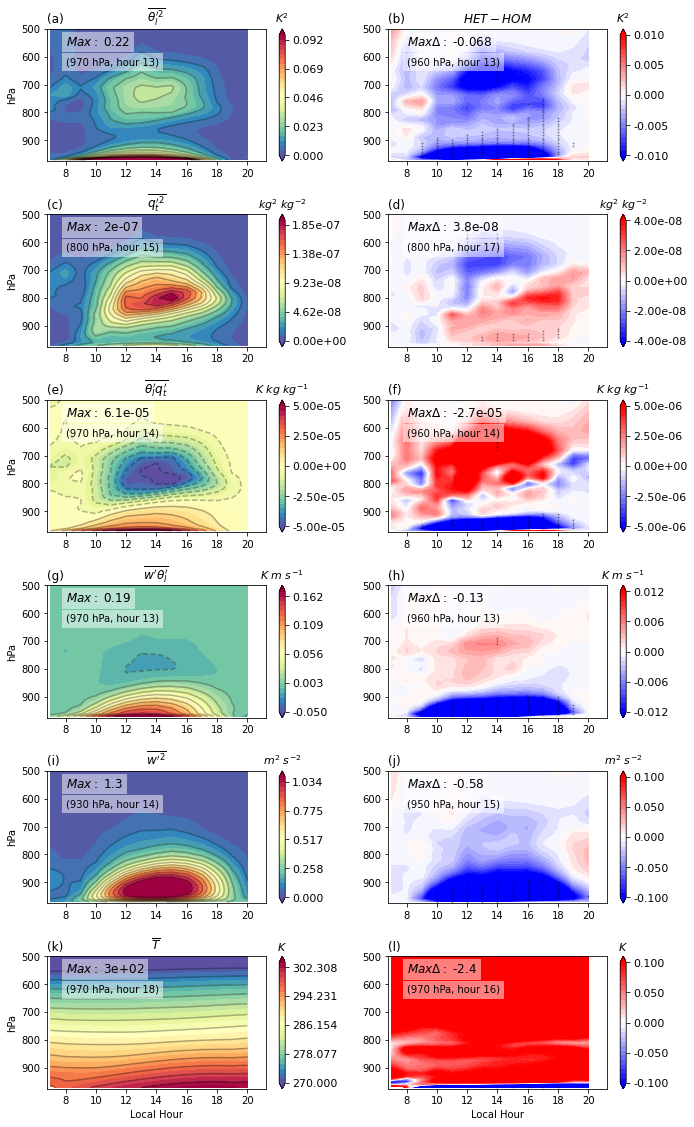

In [36]:
# Set up figure
pltVars  = ['THLP2_CLUBB_interp', 'RTP2_CLUBB_interp','RTPTHLP_CLUBB_interp',
            'WPTHLP_CLUBB_interp','WP2_CLUBB_interp', 
            'T_interp',
           ]

cMin    = [0.0, 
           0.0, 
          -5e-5,
          -0.05,
           0.0,
           270,
          ]

cMax    = [0.1,
           2.0e-7, 
           5.0e-5,
           0.18,
           1.12,
           305,
          ]

cfmt_hmg = ['%.3f', '%.2e', '%.2e', '%.3f', '%.3f','%.3f'] # colorbar label formater
cfmt_htg = ['%.3f', '%.2e', '%.2e', '%.3f', '%.3f','%.3f'] # colorbar label formater

diffMax = [0.01,
           0.4e-7, 
           5.0e-6,
           0.012, 
           0.1,
           0.1,
          ]

multpl = [1, 
          1e-6, 
          1e-3, 
          1, 
          1,
          1,
         ]

maxLev  = 500

units = [r'$K^2$',
         r'$kg^2$ $kg^{-2}$',
         r'$K$ $kg$ $kg^{-1}$',
         r'$K$ $m$ $s^{-1}$',
         r'$m^2$ $s^{-2}$',
         r'$K$',
        ]

subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [r"$\overline{\theta_l'^2}$", 
               r"$\overline{q_t'^2}$",
               r"$\overline{\theta_l'q_t'}$",
               r"$\overline{w'\theta_l'}$",
               r"$\overline{w'^2}$",
               r"$\overline{T}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'HOM_MF'
testCase = 'HET_MF'
# testCase = 'HTG*LESmult'

# ctrlCase = 'HMG_dcOff'
# # testCase = 'HTG_dcOff'
# testCase = 'HTG*LESmult_dcOff

ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$HET - HOM$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')
        


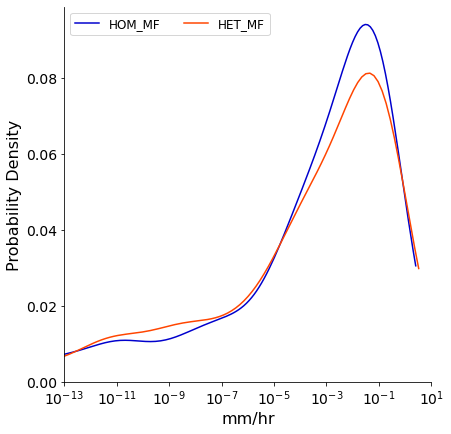

In [34]:
scamRain  = scamDS.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3)

# SCAM
rainRatesHMG_scam = scamRain.sel(case='HOM_MF').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='HET_MF').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHTG_scam>0)[0]]

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         # pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTGx100_scam), 'case': 'SCAM_HTGx100'}),
         # # pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTGx10_scam), 'case': 'SCAM_HTGx10'}),
         # pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTGalpha_scam), 'case': 'SCAM_HTGalpha'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG_scam), 'case': 'HET_MF'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG_scam), 'case': 'HOM_MF'}),
         # pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG_les), 'case': 'LES_HTG'}),
         # pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG_les), 'case': 'LES_HMG'}),
         # pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRateObs), 'case': 'Obs'})
         ])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=6, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['orangered','mediumblue'], legend=False)

g.ax.set_xlim([10**-13, 10**1])
# g.ax.set_title("Hourly rain rates (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
# plt.setp(g._legend.get_title(), fontsize=14)
# plt.setp(g._legend.get_texts(), fontsize=14)
# plt.setp(g.ax.lines[0], linestyle='-.')   # Index goes in reverse order 
# plt.setp(g.ax.lines[2], linestyle=':')   # Index goes in reverse order 
# plt.setp(g.ax.lines[5], linestyle='--')   # Index goes in reverse order 
plt.legend(loc='upper left', 
           labels=['HOM_MF','HET_MF'], 
           ncol=2, fontsize=12)


